In [1]:
# Standard imports
import pathlib

# Third party imports
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
import matplotlib.ticker as ticker

# Internal imports
import rosetta
from utils import get_Dless_parameters
from utils import timer
from rate import q_approx
from rate import q_exact
from rate import q_exact_dis
from rate import q_approx_dis
from rate import q_modflow

# add timer
q_exact = np.vectorize(timer(q_exact))
q_approx = np.vectorize(timer(q_approx))
q_exact_dis = np.vectorize(timer(q_exact_dis))
q_approx_dis = np.vectorize(timer(q_approx_dis))
q_modflow = np.vectorize(timer(q_modflow))

In [2]:
# set plot style
%matplotlib widget
plt.style.use('plot_style.txt')

# output path for figures 
output_path = pathlib.Path("/home/jonas/shared/Work/SSeep2026/Figures")

# set regime colors
c_negl = '#5a7cb0b3'
c_soft = '#e16e91b3'
c_hard = '#c9aa2ab3'

# set equation colors
c_ex = 'k'
c_ap = "#d65d17ff"
c_mf = "#14b7ccff"


### Set riverbed profile

In [3]:
### clogging layer ###
cl_th = 0.1 # [m]
cl_cond = 1e-7 # [m/s]

### aquifer ###

# from Rosetta3
aq_cond, aq_scale_vGM, aq_shape_vGM = rosetta.get_sand(1).loc[0]
aq_cond, aq_scale_vGM, aq_shape_vGM = rosetta.get_silt(1).loc[0]

# custom
#aq_cond = 0.000038 # [m/s]
#aq_scale_vGM = 0.208382 # [m]
#aq_shape_vGM = 4.763797 # [-]

# convert to BCB
b, B, xi, x, x_sh = get_Dless_parameters(cl_cond, cl_th, aq_cond, aq_scale_vGM,
                                         aq_shape_vGM, 'vGM')
aq_scale_BCB = B**(1/b) * aq_scale_vGM
aq_shape_BCB = (b - 2) / 3

print(f'Hydraulic conductivity: {aq_cond:.2e} [m/s]')
print('Unsaturated parameters:')
print(f'Generalized: b={b:.2f}, B={B:.2f}')
print(f'vGM: n={aq_shape_vGM:.2f}, hg={aq_scale_vGM:.2f}')
print(f'BCB: lambda={aq_shape_BCB:.2f}, hg={aq_scale_BCB:.2f}')

Hydraulic conductivity: 2.98e-06 [m/s]
Unsaturated parameters:
Generalized: b=2.30, B=0.01
vGM: n=1.12, hg=2.53
BCB: lambda=0.10, hg=0.36


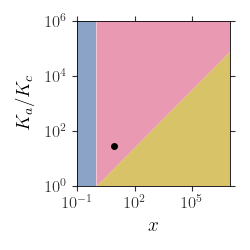

In [4]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

# plot profile
ax.plot([x], [aq_cond / cl_cond], ls='None', marker='o', ms=4, c='k')

# background with the regimes
x_bg = np.array([1e0, 1e10])
y_bg = x_bg**(b/(1+b))
ax.fill_betweenx([1e0, 1e6], [1e-2, 1e-2], x2=[1e0, 1e0], color=c_negl, 
                 ec='None', zorder=0)
ax.fill_between(x_bg, y_bg, y2=[1e10, 1e10], color=c_soft, ec='None', zorder=0)
ax.fill_between(x_bg, [1e0, 1e0], y2=y_bg, color=c_hard, ec='None', zorder=0)

ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)
ax.tick_params(top=True, right=True)
ax.set(xscale='log', yscale='log')
ax.minorticks_off()
ax.set_xlabel('$x$', labelpad=5)
ax.set_xlim(xmin=1e-1, xmax=1e7)
ax.set_ylim(ymin=1e0, ymax=1e6)
ax.set_ylabel('$K_a / K_c$', labelpad=8)
    
plt.tight_layout()

### Vary water stage

In [5]:
N = 300

# vGM
hc_vGM = cl_th * (aq_cond / cl_cond - 1)
stage_vGM = np.linspace(0, hc_vGM, N)
q_ex_vGM, t_ex_vGM = q_exact_dis(stage_vGM, cl_cond, cl_th, aq_cond, aq_scale_vGM,
                             aq_shape_vGM, 'vGM')
q_ap_vGM, t_ap_vGM = q_approx_dis(stage_vGM, cl_cond, cl_th, aq_cond,
                                   aq_scale_vGM, aq_shape_vGM, 'vGM')
q_mf_vGM, t_mf_vGM = q_modflow(stage_vGM, cl_cond, cl_th)

# BCB
hc_BCB = cl_th * (aq_cond / cl_cond - 1) - aq_scale_BCB
stage_BCB = np.linspace(0, hc_BCB, N)
q_ex_BCB, t_ex_BCB = q_exact_dis(stage_BCB, cl_cond, cl_th, aq_cond, aq_scale_BCB,
                             aq_shape_BCB, 'BCB')
q_ap_BCB, t_ap_BCB = q_approx_dis(stage_BCB, cl_cond, cl_th, aq_cond,
                                   aq_scale_BCB, aq_shape_BCB, 'BCB')
q_mf_BCB, t_mf_BCB = q_modflow(stage_BCB, cl_cond, cl_th)

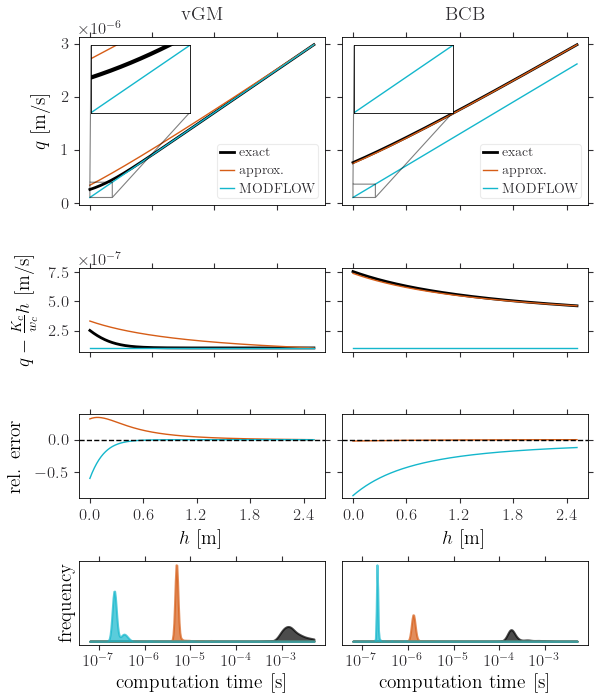

In [6]:
fig, axs = plt.subplots(4, 2, figsize=(6, 7), height_ratios=[1, 0.5, 0.5, 0.5])

### van Genuchten - Mualem ###

# first line
axs[0, 0].plot(stage_vGM, q_ex_vGM, ls='-', lw=2, c=c_ex, label='exact')
axs[0, 0].plot(stage_vGM, q_ap_vGM, ls='-', lw=1, c=c_ap, label='approx.')
axs[0, 0].plot(stage_vGM, q_mf_vGM, ls='-', lw=1, c=c_mf, label='MODFLOW')

# inset plot
xmin, xmax = 0, 0.1 * stage_vGM[-1]
ymin, ymax = cl_cond, cl_cond + cl_cond / cl_th * xmax
axins1 = axs[0, 0].inset_axes(
    [0.05, 0.55, 0.4, 0.4],
    xlim=(xmin, xmax), ylim=(ymin, ymax), 
    xticklabels=[], yticklabels=[]
)
axins1.plot(stage_vGM, q_ex_vGM, ls='-', lw=3, c=c_ex)
axins1.plot(stage_vGM, q_ap_vGM, ls='-', lw=1, c=c_ap)
axins1.plot(stage_vGM, q_mf_vGM, ls='-', lw=1, c=c_mf)

axins1.spines["top"].set_visible(True)
axins1.spines["right"].set_visible(True)
axins1.tick_params(top=True, right=True)
axins1.set(xscale='linear', yscale='linear')
axins1.minorticks_off()
axins1.set_xticks([])
axins1.set_yticks([])
axs[0, 0].indicate_inset_zoom(axins1, edgecolor="black")

# second line
q_ref = stage_vGM * cl_cond / cl_th
axs[1, 0].plot(stage_vGM, q_ex_vGM - q_ref, ls='-', lw=2, c=c_ex)
axs[1, 0].plot(stage_vGM, q_ap_vGM - q_ref, ls='-', lw=1, c=c_ap)
axs[1, 0].plot(stage_vGM, q_mf_vGM - q_ref, ls='-', lw=1, c=c_mf)

# third line
axs[2, 0].plot(stage_BCB, (q_ap_vGM - q_ex_vGM) / q_ex_vGM, ls='-', lw=1, c=c_ap)
axs[2, 0].plot(stage_BCB, (q_mf_vGM - q_ex_vGM) / q_ex_vGM, ls='-', lw=1, c=c_mf)
axs[2, 0].axhline(0, ls='--', c='k', lw=1)

# fourth line
X_ex = np.log10(t_ex_vGM)
X_ap = np.log10(t_ap_vGM)
X_mf = np.log10(t_mf_vGM)
x = np.linspace(-7.2, -2.3, 300)

kde = stats.gaussian_kde(X_ex)
y = kde(x) * X_ex.shape[0]
axs[3, 0].fill_between(10**x, 0, y, lw=1.5, color=c_ex, alpha=0.7)

kde = stats.gaussian_kde(X_ap)
y = kde(x) * X_ap.shape[0]
axs[3, 0].fill_between(10**x, 0, y, lw=1.5, color=c_ap, alpha=0.7)

kde = stats.gaussian_kde(X_mf)
y = kde(x) * X_mf.shape[0]
axs[3, 0].fill_between(10**x, 0, y, lw=1.5, color=c_mf, alpha=0.7)

axs[3, 0].set(xscale='log', yscale='linear')

### Brooks - Corey - Burdine ###

# first line
axs[0, 1].plot(stage_BCB, q_ex_BCB, ls='-', lw=2, c=c_ex, label='exact')
axs[0, 1].plot(stage_BCB, q_ap_BCB, ls='-', lw=1, c=c_ap, label='approx.')
axs[0, 1].plot(stage_BCB, q_mf_BCB, ls='-', lw=1, c=c_mf, label='MODFLOW')

# inset plot
xmin, xmax = 0, 0.1 * stage_BCB[-1]
ymin, ymax = cl_cond, cl_cond + cl_cond / cl_th * xmax
axins2 = axs[0, 1].inset_axes(
    [0.05, 0.55, 0.4, 0.4],
    xlim=(xmin, xmax), ylim=(ymin, ymax), 
    xticklabels=[], yticklabels=[]
)
axins2.plot(stage_BCB, q_ex_BCB, ls='-', lw=3, c=c_ex)
axins2.plot(stage_BCB, q_ap_BCB, ls='-', lw=1, c=c_ap)
axins2.plot(stage_BCB, q_mf_BCB, ls='-', lw=1, c=c_mf)

axins2.spines["top"].set_visible(True)
axins2.spines["right"].set_visible(True)
axins2.tick_params(top=True, right=True)
axins2.set(xscale='linear', yscale='linear')
axins2.minorticks_off()
axins2.set_xticks([])
axins2.set_yticks([])
axs[0, 1].indicate_inset_zoom(axins2, edgecolor="black")

# second line
q_ref = stage_BCB * cl_cond / cl_th
axs[1, 1].plot(stage_BCB, q_ex_BCB - q_ref, ls='-', lw=2, c=c_ex)
axs[1, 1].plot(stage_BCB, q_ap_BCB - q_ref, ls='-', lw=1, c=c_ap)
axs[1, 1].plot(stage_BCB, q_mf_BCB - q_ref, ls='-', lw=1, c=c_mf)

# third line
axs[2, 1].plot(stage_BCB, (q_ap_BCB - q_ex_BCB) / q_ex_BCB, ls='-', lw=1, c=c_ap)
axs[2, 1].plot(stage_BCB, (q_mf_BCB - q_ex_BCB) / q_ex_BCB, ls='-', lw=1, c=c_mf)
axs[2, 1].axhline(0, ls='--', c='k', lw=1)

# fourth line
X_ex = np.log10(t_ex_BCB)
X_ap = np.log10(t_ap_BCB)
X_mf = np.log10(t_mf_BCB)
x = np.linspace(-7.2, -2.3, 300)

kde = stats.gaussian_kde(X_ex)
y = kde(x) * X_ex.shape[0]
axs[3, 1].fill_between(10**x, 0, y, lw=1.5, color=c_ex, alpha=0.7)

kde = stats.gaussian_kde(X_ap)
y = kde(x) * X_ap.shape[0]
axs[3, 1].fill_between(10**x, 0, y, lw=1.5, color=c_ap, alpha=0.7)

kde = stats.gaussian_kde(X_mf)
y = kde(x) * X_mf.shape[0]
axs[3, 1].fill_between(10**x, 0, y, lw=1.5, color=c_mf, alpha=0.7)

axs[3, 1].set(xscale='log', yscale='linear')


for ax in axs.flatten():
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)
    ax.tick_params(top=True, right=True)
    ax.minorticks_off()

axs[0, 0].tick_params(labelbottom=False)
axs[0, 1].tick_params(labelleft=False, labelbottom=False)
axs[1, 0].tick_params(labelbottom=False)
axs[1, 1].tick_params(labelleft=False, labelbottom=False)
axs[2, 1].tick_params(labelleft=False)
axs[3, 0].tick_params(left=False, right=False, labelleft=False)
axs[3, 1].tick_params(left=False, right=False, labelleft=False)
for i in range(3):
    axs[i, 0].xaxis.set_major_locator(ticker.MaxNLocator(5))
    axs[i, 1].xaxis.set_major_locator(ticker.MaxNLocator(5))
axs[2, 0].set_xlabel('$h$ [m]', labelpad=5)
axs[2, 1].set_xlabel('$h$ [m]', labelpad=5)

axs[0, 1].set_ylim(axs[0, 0].get_ylim())

ylim = np.array([axs[1, 1].get_ylim(), axs[1, 0].get_ylim()])
ylim = min(ylim[:, 0]), max(ylim[:, 1])
axs[1, 0].set_ylim(ylim)
axs[1, 1].set_ylim(ylim)

ylim = np.array([axs[2, 1].get_ylim(), axs[2, 0].get_ylim()])
ylim = min(ylim[:, 0]), max(ylim[:, 1])
axs[2, 0].set_ylim(ylim)
axs[2, 1].set_ylim(ylim)

axs[0, 0].set_ylabel('$q$ [m/s]', labelpad=8)
axs[1, 0].set_ylabel('$q - \\frac{K_c}{w_c} h$ [m/s]', labelpad=8)
axs[2, 0].set_ylabel('rel. error', labelpad=8)

for i in range(2):
    axs[3, i].set(xscale='log', yscale='linear')
    axs[3, i].set_xticks([1e-7, 1e-6, 1e-5, 1e-4, 1e-3])
    axs[3, i].set_xlabel('computation time [s]')
axs[3, 0].set_ylabel('frequency')

axs[0, 0].set_title('vGM', fontsize=14, loc='center', pad=12)
axs[0, 1].set_title('BCB', fontsize=14, loc='center', pad=12)

axs[0, 0].legend(loc='lower right', handlelength=1, handletextpad=0.4, fontsize=10)
axs[0, 1].legend(loc='lower right', handlelength=1, handletextpad=0.4, fontsize=10)

plt.tight_layout(pad=0.5)
plt.savefig(output_path / 'demo_hup.pdf')

### Vary water table depth

In [31]:
# set water stage
stage = 1 # [m]

In [32]:
N_ap = 200
N_ex = 10

# vGM
hc_vGM = cl_th * (aq_cond / cl_cond - 1)
assert stage < hc_vGM

q, _ = q_exact_dis(stage, cl_cond, cl_th, aq_cond, aq_scale_vGM, aq_shape_vGM, 'vGM')
dis_WT_full = (cl_th * (q / cl_cond - 1) - stage) / (1 - q / aq_cond)
dis_WT_ap_vGM = np.linspace(0, 2 * dis_WT_full, N_ap)
dis_WT_ex_vGM = np.linspace(0, 2 * dis_WT_full, N_ex)

q_ex_vGM, t_ex_vGM = q_exact(stage, dis_WT_ex_vGM, cl_cond, cl_th, aq_cond,
                             aq_scale_vGM, aq_shape_vGM, 'vGM', max_nodes=100)
q_ap_vGM, t_ap_vGM = q_approx(stage, dis_WT_ap_vGM, cl_cond, cl_th, aq_cond,
                              aq_scale_vGM, aq_shape_vGM, 'vGM')
q_mf_vGM = q_modflow(stage, cl_cond, cl_th)[0] * np.ones(N_ap)

# BCB
hc_BCB = cl_th * (aq_cond / cl_cond - 1) - aq_scale_BCB
assert stage < hc_BCB

q, _ = q_exact_dis(stage, cl_cond, cl_th, aq_cond, aq_scale_BCB, aq_shape_BCB, 'BCB')
dis_WT_full = (cl_th * (q / cl_cond - 1) - stage) / (1 - q / aq_cond)
dis_WT_ap_BCB = np.linspace(0, 2 * dis_WT_full, N_ap)
dis_WT_ex_BCB = np.linspace(0, 2 * dis_WT_full, N_ex)

q_ex_BCB, t_ex_BCB = q_exact(stage, dis_WT_ex_BCB, cl_cond, cl_th, aq_cond,
                             aq_scale_BCB, aq_shape_BCB, 'BCB', max_nodes=100)
q_ap_BCB, t_ap_BCB = q_approx(stage, dis_WT_ap_BCB, cl_cond, cl_th, aq_cond,
                              aq_scale_BCB, aq_shape_BCB, 'BCB')
q_mf_BCB = q_modflow(stage, cl_cond, cl_th)[0] * np.ones(N_ap)

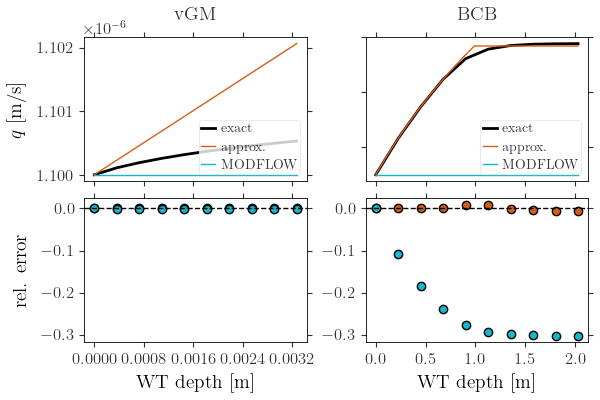

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(6, 4))

### van Genuchten - Mualem ###

# first line
axs[0, 0].plot(dis_WT_ex_vGM, q_ex_vGM, ls='-', lw=2, c=c_ex, label='exact')
axs[0, 0].plot(dis_WT_ap_vGM, q_ap_vGM, ls='-', lw=1, c=c_ap, label='approx.')
axs[0, 0].plot(dis_WT_ap_vGM, q_mf_vGM, ls='-', lw=1, c=c_mf, label='MODFLOW')

# second line
q_ap_vGM_interp = np.interp(dis_WT_ex_vGM, dis_WT_ap_vGM, q_ap_vGM)
q_mf_vGM_interp = np.interp(dis_WT_ex_vGM, dis_WT_ap_vGM, q_mf_vGM)

axs[1, 0].plot(dis_WT_ex_vGM, (q_ap_vGM_interp - q_ex_vGM) / q_ex_vGM,
               ls='None', marker='o', c=c_ap)
axs[1, 0].plot(dis_WT_ex_vGM, (q_mf_vGM_interp - q_ex_vGM) / q_ex_vGM,
               ls='None', marker='o', c=c_mf)
axs[1, 0].axhline(0, ls='--', c='k', lw=1)

### Brooks - Corey - Burdine ###

# first line
axs[0, 1].plot(dis_WT_ex_BCB, q_ex_BCB, ls='-', lw=2, c=c_ex, label='exact')
axs[0, 1].plot(dis_WT_ap_BCB, q_ap_BCB, ls='-', lw=1, c=c_ap, label='approx.')
axs[0, 1].plot(dis_WT_ap_BCB, q_mf_BCB, ls='-', lw=1, c=c_mf, label='MODFLOW')

# second line
q_ap_BCB_interp = np.interp(dis_WT_ex_BCB, dis_WT_ap_BCB, q_ap_BCB)
q_mf_BCB_interp = np.interp(dis_WT_ex_BCB, dis_WT_ap_BCB, q_mf_BCB)

axs[1, 1].plot(dis_WT_ex_BCB, (q_ap_BCB_interp - q_ex_BCB) / q_ex_BCB,
               ls='None', marker='o', c=c_ap)
axs[1, 1].plot(dis_WT_ex_BCB, (q_mf_BCB_interp - q_ex_BCB) / q_ex_BCB,
               ls='None', marker='o', c=c_mf)
axs[1, 1].axhline(0, ls='--', c='k', lw=1)


for ax in axs.flatten():
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)
    ax.tick_params(top=True, right=True)
    ax.minorticks_off()

axs[0, 0].tick_params(labelbottom=False)
axs[0, 1].tick_params(labelleft=False, labelbottom=False)
for i in range(2):
    axs[i, 0].xaxis.set_major_locator(ticker.MaxNLocator(5))
    axs[i, 1].xaxis.set_major_locator(ticker.MaxNLocator(5))
axs[1, 0].set_xlabel('WT depth [m]', labelpad=5)
axs[1, 1].set_xlabel('WT depth [m]', labelpad=5)

ylim = np.array([axs[1, 1].get_ylim(), axs[1, 0].get_ylim()])
ylim = min(ylim[:, 0]), max(ylim[:, 1])
axs[1, 0].set_ylim(ylim)
axs[1, 1].set_ylim(ylim)

axs[0, 0].set_ylabel('$q$ [m/s]', labelpad=8)
axs[1, 0].set_ylabel('rel. error', labelpad=8)

axs[0, 0].set_title('vGM', fontsize=14, loc='center', pad=12)
axs[0, 1].set_title('BCB', fontsize=14, loc='center', pad=12)

axs[0, 0].legend(loc='lower right', handlelength=1, handletextpad=0.4, fontsize=10)
axs[0, 1].legend(loc='lower right', handlelength=1, handletextpad=0.4, fontsize=10)

plt.tight_layout(pad=0.5)
#plt.savefig(output_path / 'demo_WTdepth.pdf')

In [ ]:
print('Computation times [s]:')
print(f'[vGM] exact: {t_ex_vGM.mean():.2e} (mean) / {t_ex_vGM.std():.2e} (std)')
print(f'[BCB] exact: {t_ex_BCB.mean():.2e} (mean) / {t_ex_BCB.std():.2e} (std)')
print(f'[vGM] approx: {t_ap_vGM.mean():.2e} (mean) / {t_ap_vGM.std():.2e} (std)')
print(f'[BCB] approx: {t_ap_BCB.mean():.2e} (mean) / {t_ap_BCB.std():.2e} (std)')